# Telco Customer Churn Prediction — Advanced Modeling & Evaluation

### Step 1: Load Data and Train-Test Split (from previous step)

In [18]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load preprocessed dataset (adjust path if needed)
df = pd.read_csv('../data/preprocessed_telco.csv')
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].mean(), inplace=True)
# df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Feature engineering if needed (optional repeat from baseline notebook)
X = df.drop(['customerID', 'Churn'], axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


/tmp/ipykernel_262659/3343402588.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].mean(), inplace=True)


### Step 2: Handle Class Imbalance with SMOTE

In [19]:

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print(f"Before SMOTE: {y_train.value_counts()}")
print(f"After SMOTE: {y_train_sm.value_counts()}")


Before SMOTE: Churn
0    4139
1    1495
Name: count, dtype: int64
After SMOTE: Churn
0    4139
1    4139
Name: count, dtype: int64


### Step 3: Random Forest Classifier

In [20]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_sm, y_train_sm)
y_pred_rf = rf.predict(X_test)

print("Random Forest Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_rf):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_rf):.4f}")


Random Forest Performance:
Accuracy: 0.7630
Precision: 0.5459
Recall: 0.6364
F1 Score: 0.5877
ROC-AUC: 0.7225


### Step 4: XGBoost Classifier with Hyperparameter Tuning

In [21]:

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

xgb = XGBClassifier(eval_metric='logloss', random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='roc_auc', cv=3, verbose=1, n_jobs=-1)
grid_xgb.fit(X_train_sm, y_train_sm)

print(f"Best Parameters: {grid_xgb.best_params_}")
y_pred_xgb = grid_xgb.best_estimator_.predict(X_test)

print("XGBoost Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_xgb):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_xgb):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_xgb):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_xgb):.4f}")

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}
XGBoost Performance:
Accuracy: 0.7601
Precision: 0.5415
Recall: 0.6283
F1 Score: 0.5817
ROC-AUC: 0.7180


### Step 5: Model Comparison Table

In [22]:

comparison = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost'],
    'Accuracy': [accuracy_score(y_test, y_pred_rf), accuracy_score(y_test, y_pred_xgb)],
    'Precision': [precision_score(y_test, y_pred_rf), precision_score(y_test, y_pred_xgb)],
    'Recall': [recall_score(y_test, y_pred_rf), recall_score(y_test, y_pred_xgb)],
    'F1 Score': [f1_score(y_test, y_pred_rf), f1_score(y_test, y_pred_xgb)],
    'ROC-AUC': [roc_auc_score(y_test, y_pred_rf), roc_auc_score(y_test, y_pred_xgb)]
})

comparison.set_index('Model').round(4)


,Accuracy,Precision,Recall,F1 Score,ROC-AUC
Model,,,,,
Random Forest,0.7630,0.5459,0.6364,0.5877,0.7225
XGBoost,0.7601,0.5415,0.6283,0.5817,0.7180


### Step 6: Feature Importance from XGBoost

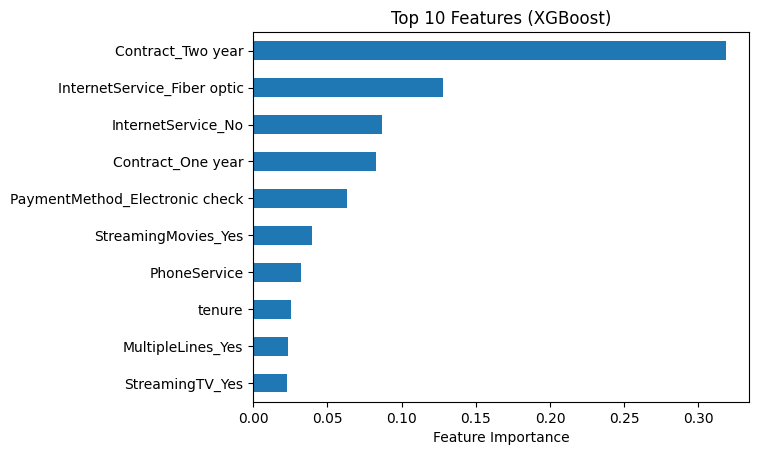

In [23]:

import matplotlib.pyplot as plt

importances = pd.Series(grid_xgb.best_estimator_.feature_importances_, index=X_train.columns)
importances.nlargest(10).plot(kind='barh')
plt.xlabel('Feature Importance')
plt.title('Top 10 Features (XGBoost)')
plt.gca().invert_yaxis()
plt.show()
